In [1]:
#准备工作，引入一些必要的库以及导入数据
import numpy as np
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
np.random.seed(66)

In [2]:
def relu(x):
    return np.maximum(x,0)
def cross_entropy_loss(y, t, epsilon=1e-15):
    y = np.clip(y, epsilon, 1 - epsilon)
    return -np.sum(t * np.log(y)) / len(y)

为了便于编程，输入输出的图片以及kernel都为三维，kernel的通道以及个数相乘作为第一个维度

In [3]:
# 定义卷积层（多通道卷积）
# input_image的shape是height,width
# kernels是多个kernel
# stride是步幅
# padding是填充的宽度
class Convolution:
    def __init__(self, num_kernels, input_image_channels, kernel_size=(3, 3), stride=1, padding=0):
        self.input_image_channels = input_image_channels
        self.last_input = None
        self.num_kernels = num_kernels * input_image_channels
        self.kernel_height, self.kernel_width = kernel_size
        self.kernels = np.random.randn(self.num_kernels,self.kernel_height,self.kernel_width)
        self.stride = stride
        self.padding = padding
        self.output_image_height = 0
        self.output_image_width = 0
        # 初始化Adam算法的参数
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.moment1 = np.zeros_like(self.kernels)
        self.moment2 = np.zeros_like(self.kernels)
        self.t = 0
    def iterate(self, input_image):
        padded_image = np.pad(input_image, ((0,0),(self.padding, self.padding), (self.padding, self.padding)), mode='constant', constant_values=0)
        for j in range(0,self.output_image_height*self.stride,self.stride):
            for k in range(0,self.output_image_width*self.stride,self.stride):
                image_region = padded_image[:,j:j+self.kernel_height,k:k+self.kernel_width]
                yield image_region, j, k
    # 计算本次卷积之后输出的图像的大小的
    def calculate_output_image_size(self,input_image_height,input_image_width):
        output_image_height = (input_image_height - self.kernel_height + 2 * self.padding) // self.stride+1
        output_image_width = (input_image_width - self.kernel_width + 2 * self.padding) // self.stride+1
        return output_image_height, output_image_width
    def forward(self,input_image):
        self.last_input = input_image
        input_image_channels,input_image_height,input_image_width = input_image.shape
        self.output_image_height = (input_image_height - self.kernel_height + 2 * self.padding) // self.stride+1
        self.output_image_width = (input_image_width - self.kernel_width + 2 * self.padding) // self.stride+1
        output_image = np.zeros((self.num_kernels,self.output_image_height,self.output_image_width))
        for image_region,j,k in self.iterate(input_image):
            nums_image = image_region.shape[0]
            for f in range(self.num_kernels//nums_image):
                for num_image in range(nums_image):
                    output_image[f*nums_image+num_image,j//self.stride,k//self.stride] = np.sum(image_region[num_image] * self.kernels[f*nums_image+num_image])  
        return output_image
    def backward(self,d_L_d_out,learn_rate):
        # 不适应adam
        # d_L_d_kernels = np.zeros(self.kernels.shape)
        # for image_region, j, k in self.iterate(self.last_input):
        #     nums_image = image_region.shape[0]
        #     for f in range(self.num_kernels//nums_image):
        #         for num_image in range(nums_image):
        #             d_L_d_kernels[f*nums_image+num_image] += d_L_d_out[f*nums_image+num_image, j, k] * image_region[num_image]
        # self.kernels -= learn_rate * d_L_d_kernels
        # return d_L_d_kernels
        d_L_d_filters = np.zeros(self.kernels.shape)
        for image_region, j, k in self.iterate(self.last_input):
            nums_image = image_region.shape[0]
            for f in range(self.num_kernels // nums_image):
                for num_image in range(nums_image):
                    d_L_d_filters[f * nums_image + num_image] += d_L_d_out[f * nums_image + num_image, j, k] * image_region[num_image]
        # Adam算法更新卷积核权重
        self.t += 1
        self.moment1 = self.beta1 * self.moment1 + (1 - self.beta1) * d_L_d_filters
        self.moment2 = self.beta2 * self.moment2 + (1 - self.beta2) * (d_L_d_filters ** 2)
        moment1_hat = self.moment1 / (1 - self.beta1 ** self.t)
        moment2_hat = self.moment2 / (1 - self.beta2 ** self.t)
        self.kernels -= learn_rate * moment1_hat / (np.sqrt(moment2_hat) + self.epsilon)
        return d_L_d_filters

In [4]:
# 定义最大池化层（无填充（我看有些人做最大池化也会填充，不过一般都没，所以还是说明一下））
# 这一层输入的图像的channel就是等于上一层使用的卷积核的数量，最大池化之后channel不变
class MaxPooling:
    def __init__(self,pool_size=(2,2),stride=2):
        self.last_input = None
        self.pool_height,self.pool_width, = pool_size
        self.stride = stride
        self.output_image_width = 0
        self.output_image_height = 0
    def iterate(self, input_image):
        for j in range(0, self.output_image_height * self.stride, self.stride):
            for k in range(0, self.output_image_width * self.stride, self.stride):
                image_region = input_image[:,j:j+self.pool_height,k:k+self.pool_width]
                yield image_region, j ,k
    def calculate_output_image_size(self,input_image_height,input_image_width):
        output_image_height = (input_image_height - self.pool_height) // self.stride + 1
        output_image_width = (input_image_width - self.pool_width) // self.stride + 1
        return output_image_height,output_image_width
    def forward(self,input_image):
        self.last_input = input_image
        image_channels,input_image_height,input_image_width = input_image.shape
        self.output_image_height = (input_image_height - self.pool_height) // self.stride + 1
        self.output_image_width = (input_image_width - self.pool_width) // self.stride + 1
        output_image = np.zeros((image_channels, self.output_image_height, self.output_image_width))
        for image_region,j,k in self.iterate(input_image):
            output_image[:,j//self.stride,k//self.stride] = np.amax(image_region,axis=(1,2))
        #channels不变,output_image的shape为output_image_channels,height,width
        return output_image
    def backward(self,d_L_d_out):
        d_L_d_input = np.zeros(self.last_input.shape)
        for image_region, i, j in self.iterate(self.last_input):
            # 获取 im_region 里面最大值的索引向量，一叠的感觉
            a_max = np.amax(image_region, axis=(1, 2))
            channel = image_region.shape[0]
            # 遍历整个 im_region，对于传递下去的像素点，修改 gradient 为 loss 对 output 的gradient
            for i2 in range(self.pool_height):
                for j2 in range(self.pool_width):
                    for f2 in range(channel):
                        # If this pixel was the max value, copy the gradient to it.
                        if image_region[f2, i2, j2] == a_max[f2]:
                            if i//self.pool_height >= d_L_d_out.shape[1]  or j//self.pool_width >= d_L_d_out.shape[2]: # 上采样确实超过范围的参数，只能进行丢弃
                                break
                            else:
                                d_L_d_input[f2, i + i2, j + j2] = d_L_d_out[f2,i//self.pool_height, j//self.pool_width]
        return d_L_d_input

In [5]:
# 定义softmax
class Softmax:
    def __init__(self, input_len, classes_num):
        self.last_input_shape = None
        self.last_input = None
        self.last_output_class = None
        self.weights = np.random.randn(input_len, classes_num) / input_len
        self.biases = np.zeros(classes_num)
    def forward(self,input_image):
        self.last_input_shape = input_image.shape
        input_image = input_image.flatten()
        self.last_input = input_image
        output_class = np.dot(input_image,self.weights) + self.biases
        self.last_output_class = output_class
        exp_output = np.exp(self.last_output_class - np.max(self.last_output_class))
        return exp_output/np.sum(exp_output,axis=0) 
    def backward(self, d_L_d_out, learn_rate):
        for i, gradient in enumerate(d_L_d_out):
            if gradient == 0:
                continue
            # e^totals
            max_val = np.max(self.last_output_class)
            t_exp = np.exp(self.last_output_class - max_val)
            # Sum of all e^totals
            S = np.sum(t_exp) 
            # Gradients of out[i] against totals
            d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
            d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)
            # Gradients of totals against weights/biases/input
            d_t_d_w = self.last_input
            d_t_d_b = 1
            d_t_d_inputs = self.weights
            # Gradients of loss against totals
            d_L_d_t = gradient * d_out_d_t
            # Gradients of loss against weights/biases/input
            d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
            d_L_d_b = d_L_d_t * d_t_d_b
            d_L_d_inputs = d_t_d_inputs @ d_L_d_t
            # 更新weights和biases
            self.weights -= learn_rate * d_L_d_w
            self.biases -= learn_rate * d_L_d_b
            return d_L_d_inputs.reshape(self.last_input_shape)

In [6]:
#数据归一化，加速训练过程
#把数据reshape一下，变成有channel的，因为写的代码会对多channel的数据集训练模型，也就是想做适用性广一些的模型
X_train = X_train.reshape((60000, 1, 28, 28)).astype('float32') / 255
X_test = X_test.reshape((10000, 1, 28, 28)).astype('float32') / 255
#对labels进行独热编码
def encode_labels(labels):
    l = len(labels)
    output = np.zeros((l, 10))
    for i in range(l):
        output[i][labels[i]] = 1
    return output

y_train = encode_labels(y_train)
y_test = encode_labels(y_test)
X_yan = X_train[2400:2800]
y_yan = y_train[2400:2800]
X_train = X_train[:2400]
y_train = y_train[:2400]
X_test = X_test[:400]
y_test = y_test[:400]

In [7]:
kernel_1_num = 8
kernel_1_size = (5,5)
pool_1_size = (2,2)
pool_1_stride = 2
kernel_2_num = 16
kernel_2_size = (3,3)
pool_2_size = (2,2)
pool_2_stride = 2

In [8]:
conv1 = Convolution(kernel_1_num, 1, kernel_1_size)
pool1 = MaxPooling(pool_1_size,pool_1_stride)
conv2 = Convolution(kernel_2_num, kernel_1_num * 1, kernel_2_size)
pool2 = MaxPooling(pool_2_size,pool_2_stride)

sh,sw = conv1.calculate_output_image_size(X_train.shape[2],X_train.shape[3])
sh,sw = pool1.calculate_output_image_size(sh,sw)
sh,sw = conv2.calculate_output_image_size(sh,sw)
sh,sw = pool2.calculate_output_image_size(sh,sw)

softmax = Softmax(sh*sw*kernel_1_num*kernel_2_num*1, 10)
def dropout_forward(X, p):
    mask = (np.random.rand(*X.shape) < p) / (1 - p)
    return X * mask, mask

def dropout_backward(dout, mask):
    return dout * mask
#加入dropout的训练过程
def train(image, y, lr = 0.001, dropout_prob1 = 0.39,dropout_prob2 = 0.39):
    # Forward pass with dropout
    Out = conv1.forward(image)
    Out = relu(Out)
    Out, mask1 = dropout_forward(Out, dropout_prob1)  # Add dropout after the first layer
    Out = pool1.forward(Out)
    Out = conv2.forward(Out)
    Out = relu(Out)
    Out, mask2 = dropout_forward(Out, dropout_prob2)  # Add dropout after the second layer
    Out = pool2.forward(Out)
    Out = softmax.forward(Out)
    
    # Loss calculation
    Loss = cross_entropy_loss(Out, y)
    
    # Accuracy calculation
    Acc = 1 if np.argmax(Out) == np.argmax(y) else 0
    
    # Calculate initial gradient
    gradient = np.zeros(10)
    gradient[np.argmax(y)] = -1 / Out[np.argmax(y)]
    
    # Backward pass with dropout
    gradient = softmax.backward(gradient, lr)
    gradient = pool2.backward(gradient)
    gradient = dropout_backward(gradient, mask2)  # Backward pass for dropout after the second layer
    gradient = conv2.backward(gradient, lr)
    gradient = pool1.backward(gradient)
    gradient = dropout_backward(gradient, mask1)  # Backward pass for dropout after the first layer
    conv1.backward(gradient, lr)
    return Loss, Acc


In [9]:
show_loss = []
show_acc = [0]

#采用mini-batch训练
batch_size = 120  # 选择适当的批量大小
avg_accuracy = 0
for epoch in range(10):
    # 打乱训练数据
    image_permutation = np.random.permutation(X_train.shape[0])
    train_images = X_train[image_permutation]
    train_labels = y_train[image_permutation]
    # 在小批量中训练
    for i in range(0, len(X_train), batch_size):
        if i+batch_size > len(X_train):
            break
        batch_images = train_images[i:i+batch_size]
        batch_labels = train_labels[i:i+batch_size]
        # 初始化批次级别的损失和准确性
        batch_loss = 0
        batch_correct = 0
        # 处理小批量中的每个样本
        for image, label in zip(batch_images, batch_labels):
            Loss, Acc = train(image, label)
            batch_loss += Loss
            batch_correct += Acc
        # 计算小批量的平均损失和准确性
        avg_loss = batch_loss / batch_size
        show_loss.append(avg_loss)
        avg_accuracy = batch_correct / batch_size
        print('第 %d 轮,第 %d 批: Loss: %.3f , Accuracy: %.2f%%'%(epoch + 1, i // batch_size + 1, avg_loss, avg_accuracy * 100))
    show_acc.append(avg_accuracy)

第 1 轮,第 1 批: Loss: 2.421 , Accuracy: 26.67%
第 1 轮,第 2 批: Loss: 1.766 , Accuracy: 44.17%
第 1 轮,第 3 批: Loss: 1.423 , Accuracy: 54.17%
第 1 轮,第 4 批: Loss: 1.136 , Accuracy: 63.33%
第 1 轮,第 5 批: Loss: 0.885 , Accuracy: 73.33%
第 1 轮,第 6 批: Loss: 0.927 , Accuracy: 70.00%
第 1 轮,第 7 批: Loss: 0.760 , Accuracy: 75.83%
第 1 轮,第 8 批: Loss: 1.258 , Accuracy: 60.83%
第 1 轮,第 9 批: Loss: 0.728 , Accuracy: 76.67%
第 1 轮,第 10 批: Loss: 0.572 , Accuracy: 80.00%
第 1 轮,第 11 批: Loss: 0.701 , Accuracy: 77.50%
第 1 轮,第 12 批: Loss: 0.804 , Accuracy: 73.33%
第 1 轮,第 13 批: Loss: 0.896 , Accuracy: 73.33%
第 1 轮,第 14 批: Loss: 0.726 , Accuracy: 75.83%
第 1 轮,第 15 批: Loss: 0.687 , Accuracy: 78.33%
第 1 轮,第 16 批: Loss: 0.505 , Accuracy: 84.17%
第 1 轮,第 17 批: Loss: 0.668 , Accuracy: 77.50%
第 1 轮,第 18 批: Loss: 0.375 , Accuracy: 87.50%
第 1 轮,第 19 批: Loss: 0.654 , Accuracy: 79.17%
第 1 轮,第 20 批: Loss: 0.473 , Accuracy: 85.00%
第 2 轮,第 1 批: Loss: 0.333 , Accuracy: 87.50%
第 2 轮,第 2 批: Loss: 0.500 , Accuracy: 84.17%
第 2 轮,第 3 批: Loss: 0.

In [10]:
print('\n--- 验证 ---')
loss = 0
num_correct = 0

for x, (a_image, a_label) in enumerate(zip(X_yan, y_yan)):
    out = conv1.forward(a_image)
    out = relu(out)
    out = pool1.forward(out)
    out = conv2.forward(out)
    out = relu(out)
    out = pool2.forward(out)
    out = softmax.forward(out)
    ls = cross_entropy_loss(out, a_label)
    accuracy = 1 if np.argmax(out) == np.argmax(a_label) else 0
    loss += ls
    num_correct += accuracy

num_yan = len(X_yan)
print('验证集的损失:', loss / num_yan)
print('验证集的准确度:', num_correct / num_yan)


--- 验证 ---
验证集的损失: 0.15112329410532654
验证集的准确度: 0.92


In [11]:
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0

predict_labels = np.zeros((y_test.shape[0],10))
show_loss_test = []
for x, (a_image, a_label) in enumerate(zip(X_test, y_test)):
    out = conv1.forward(a_image)
    out = relu(out)
    out = pool1.forward(out)
    out = conv2.forward(out)
    out = relu(out)
    out = pool2.forward(out)
    out = softmax.forward(out)
    predict_labels[x][np.argmax(out)] = 1
    ls = cross_entropy_loss(out, a_label)
    accuracy = 1 if np.argmax(out) == np.argmax(a_label) else 0
    loss += ls
    num_correct += accuracy

num_tests = len(X_test)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)


--- Testing the CNN ---
Test Loss: 0.07932084417901103
Test Accuracy: 0.9275


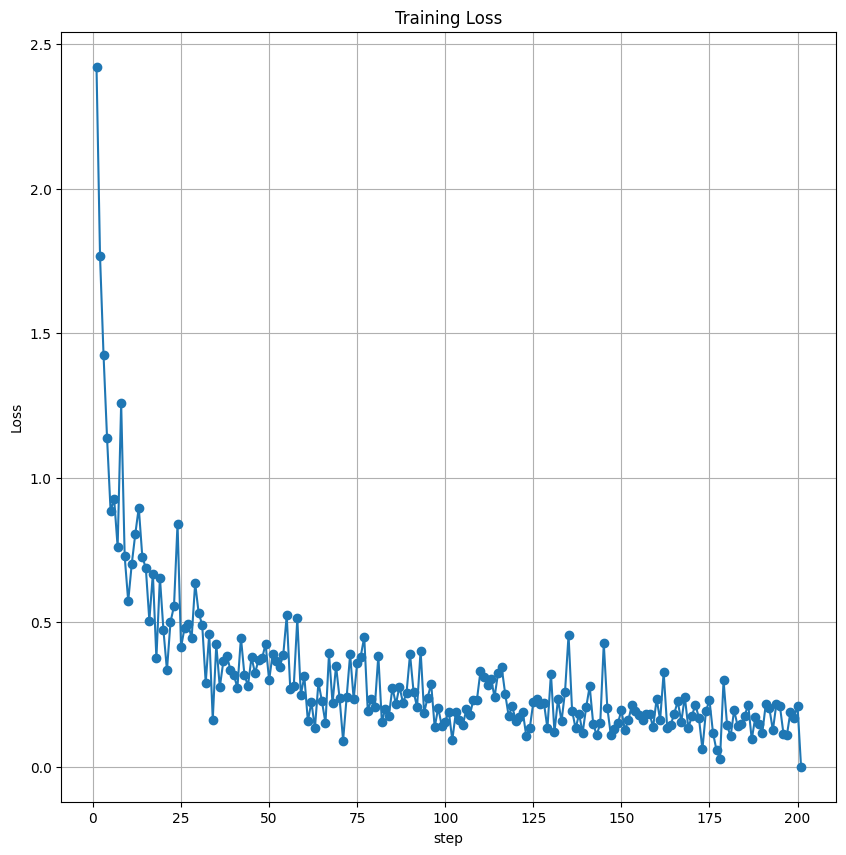

In [12]:
import matplotlib.pyplot as plt
show_loss.append(0)
plt.figure(figsize=(10, 10))
plt.plot(range(1, len(show_loss) + 1), show_loss, marker='o')
plt.title('Training Loss')
plt.xlabel('step')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

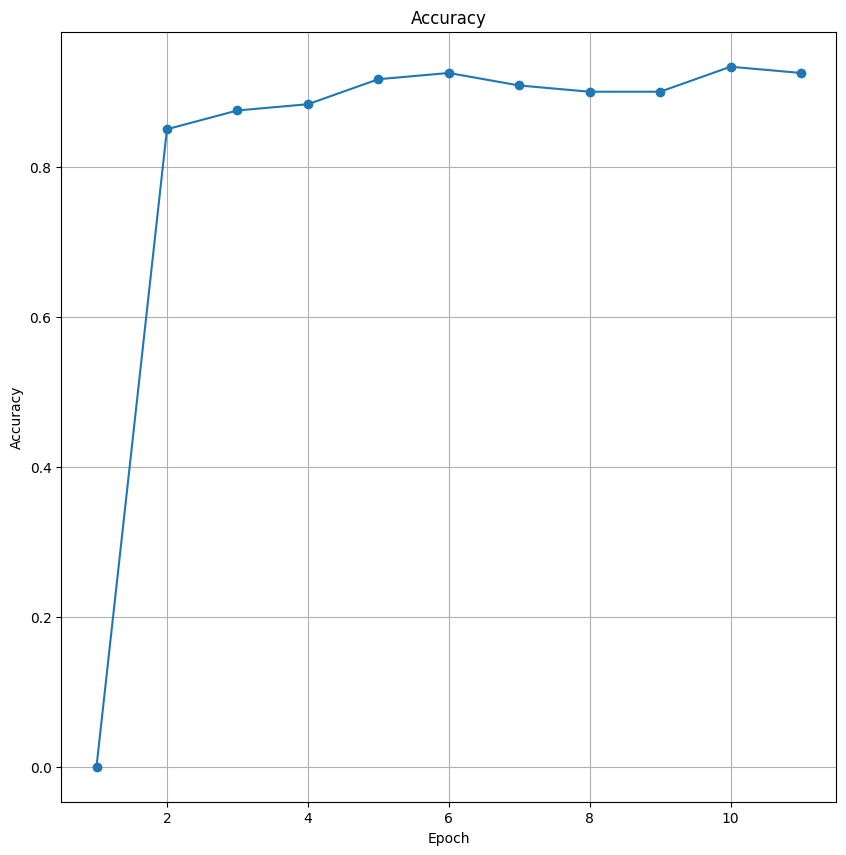

In [13]:
plt.figure(figsize=(10, 10))
plt.plot(range(1,len(show_acc) + 1), show_acc, marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

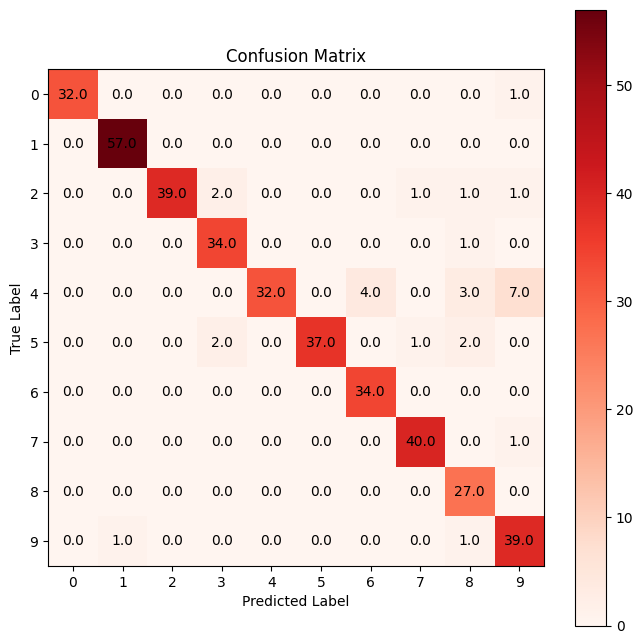

In [14]:
# 计算混淆矩阵
confusion_matrix = np.dot(y_test.T, predict_labels)
# 创建图像
plt.figure(figsize=(8,8))
plt.imshow(confusion_matrix, cmap='Reds', interpolation='nearest')
# 添加颜色标尺
plt.colorbar()
# 添加标签
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# 显示标签的刻度
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))
# 显示混淆矩阵的数值
for i in range(10):
    for j in range(10):
        plt.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center', color='black')
# 显示图像
plt.show()


In [15]:
import pickle
def save_kernel(kernel,name):
    with open(name+".pickle", "wb") as file:
        pickle.dump(kernel, file)
save_kernel(conv1,"conv1")
save_kernel(conv2,"conv2")
save_kernel(softmax,"softmax")